<a href="https://colab.research.google.com/github/yashc73080/CS462-Deep-Learning/blob/main/HW3/sequences.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms.functional as TF
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, Dataset
import numpy as np
import matplotlib.pyplot as plt
import time
import random
from tqdm.auto import tqdm

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

torch.manual_seed(0)
np.random.seed(0)

Using device: cuda


# 1. Change Point Detection

## Data Generation

$t = 0 → s(0) = [x_{00}, x_{01}, ..., x_{09}] \\
t = 1 → s(1) = [x_{10}, x_{11}, ..., x_{19}] \\
t = 2 → s(2) = [x_{20}, x_{21}, ..., x_{29}] \\
\cdots \\
t = 99 → s(99)$

In [4]:
def generate_sequence(max_T=100):
    length = max_T

    # Decide change point including "no change"
    T = random.randint(0, length)

    # Create the full sequence of shape (length, 10)
    seq = torch.randn(length, 10)

    # Pick 5 indices out of 10
    indices = random.sample(range(10), 5)

    # Create means for these indices
    mus = {idx: random.uniform(-1, 1) for idx in indices}

    # Apply shift only after change point
    if T < length:
        for idx in indices:
            seq[T:, idx] += mus[idx]

    # Label: 0 if no change happened yet, 1 if change occurred
    label = 1 if T < length else 0

    return seq, label, T


In [5]:
class ChangePointDataset(Dataset):
    def __init__(self, num_sequences, device='cpu'):
        self.num_sequences = num_sequences
        self.device = device

    def __len__(self):
        return self.num_sequences

    def __getitem__(self, idx):
        seq, label, T = generate_sequence()
        seq = seq.to(self.device)
        labels = torch.zeros(seq.shape[0], 1, device=self.device)
        labels[T:] = 1
        return seq, labels, T

Get dataset

In [6]:
dataset = ChangePointDataset(15000, device=device)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

## RNN and LSTM model definitions

In [7]:
class RNNModel(nn.Module):
    def __init__(self, input_size=10, hidden_size=20, output_size=1, num_layers=1,device='cpu'):
        super(RNNModel, self).__init__()

        self.rnn = nn.RNN(input_size, hidden_size, num_layers=num_layers, bias=True,
                          dropout=0, bidirectional=False, batch_first=True)

        self.fc = nn.Linear(hidden_size, output_size)

        self.to(device)

    def forward(self, x):
        # input x: (batch_size, time, features)
        out, _ = self.rnn(x) # out: (batch_size, time, hidden_size)
        logits = self.fc(out) # logits: (batch_size, time, 1)
        probability = torch.sigmoid(logits) # probability: (batch_size, time, 1)

        return probability

In [8]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=10, hidden_size=20, output_size=1, num_layers=1, device='cpu'):
        super(LSTMModel, self).__init__()

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers,
                            bias=True, dropout=0.3, batch_first=True)

        self.layer_norm = nn.LayerNorm(hidden_size)

        self.fc = nn.Linear(hidden_size, output_size)

        self.to(device)

    def forward(self, x):
        # input x: (batch_size, time, features)
        out, _ = self.lstm(x) # out: (batch_size, time, hidden_size)

        out = self.layer_norm(out)

        logits = self.fc(out) # logits: (batch_size, time, 1)
        probability = torch.sigmoid(logits) # probability: (batch_size, time, 1)

        return probability

In [9]:
def train_model(model, dataloader, num_epochs=10, lr=0.01, plot=False):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    model.train()

    loss_history = []

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for sequences, labels, T_values in dataloader:
            optimizer.zero_grad()

            outputs = model(sequences)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * sequences.size(0)

        epoch_loss /= len(dataloader.dataset)
        loss_history.append(epoch_loss)

        if epoch % 5 == 0 or epoch == num_epochs - 1:
            print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

    if plot:
        plt.plot(loss_history)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training Loss History')
        plt.show()

    return model, loss_history

In [10]:
def get_probabilities(model, seq):
    model.eval()
    with torch.no_grad():
        seq = seq.unsqueeze(0)          # (1, 100, 10)
        prob = model(seq).squeeze()     # (100,)
    return prob

def plot_probabilities(probabilities, T):
    # Create x-axis relative to T
    time_steps = np.arange(len(probabilities))
    relative_time = time_steps - T

    plt.figure(figsize=(10, 4))
    plt.plot(relative_time, probabilities.cpu().numpy(), label='Predicted Probability')
    plt.axvline(x=0, color='green', linestyle='-', label='Change Point (T)')

    plt.xlabel('Time Relative to Change Point (t - T)')
    plt.ylabel('Probability')
    plt.title(f'Detection Probability (Change Point at T={T})')
    plt.legend()
    plt.grid()
    plt.show()

def evaluate_and_plot_aggregate(model, dataloader, device):
    model.eval()

    # Dictionary to store probabilities for each relative time step (t - T)
    # Key: relative_time, Value: list of probabilities
    rel_probs = {}

    with torch.no_grad():
        for seq, _, T_val in dataloader:
            seq = seq.to(device)
            probs = model(seq).squeeze(-1).cpu().numpy() # (batch, time)
            T_val = T_val.numpy()

            for i in range(seq.shape[0]): # Loop over batch
                T = T_val[i]
                length = seq.shape[1]

                # Only consider sequences where a change actually occurred within the window
                if T < length:
                    for t in range(length):
                        rel_t = t - T
                        if rel_t not in rel_probs:
                            rel_probs[rel_t] = []
                        rel_probs[rel_t].append(probs[i, t])

    # Calculate averages
    x_vals = sorted(rel_probs.keys())
    y_vals = [np.mean(rel_probs[x]) for x in x_vals]

    # Get a window
    plot_x = []
    plot_y = []
    for x, y in zip(x_vals, y_vals):
        if -50 <= x <= 50:
            plot_x.append(x)
            plot_y.append(y)

    plt.figure(figsize=(10, 5))
    plt.plot(plot_x, plot_y, marker='o')
    plt.axvline(0, color='r', linestyle='--', label='Change Point')
    plt.xlabel('Distance from Change Point (t - T)')
    plt.ylabel('Average Detection Probability')
    plt.title('Average Detection Probability vs. Time')
    plt.grid(True)
    plt.legend()
    plt.show()

## Testing RNN

Epoch 1/50, Loss: 0.6981
Epoch 6/50, Loss: 0.5382
Epoch 11/50, Loss: 0.4529
Epoch 16/50, Loss: 0.4288
Epoch 21/50, Loss: 0.4010
Epoch 26/50, Loss: 0.4004
Epoch 31/50, Loss: 0.3889
Epoch 36/50, Loss: 0.3849
Epoch 41/50, Loss: 0.3708
Epoch 46/50, Loss: 0.3709
Epoch 50/50, Loss: 0.3744


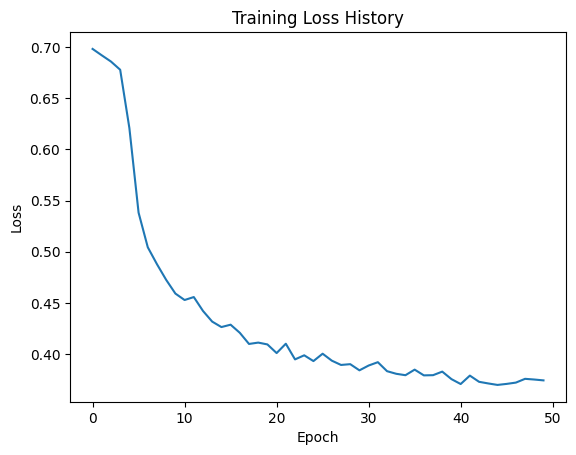

In [ ]:
rnn = RNNModel(input_size=10, hidden_size=20, output_size=1, device=device)
rnn, loss_history = train_model(rnn, dataloader, num_epochs=50, lr=0.001, plot=True)

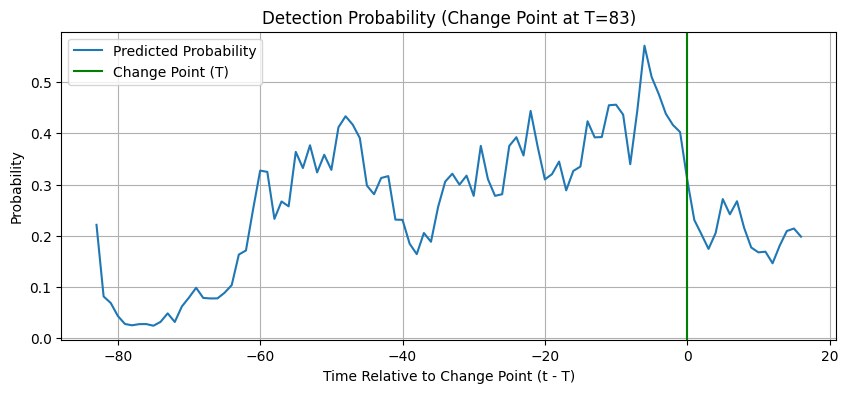

In [ ]:
seq, label, T = dataloader.dataset[0]
probabilities = get_probabilities(rnn, seq)
plot_probabilities(probabilities, T)

## Testing LSTM

Epoch 1/70, Loss: 0.4894
Epoch 6/70, Loss: 0.2731
Epoch 11/70, Loss: 0.2598
Epoch 16/70, Loss: 0.2573
Epoch 21/70, Loss: 0.2548
Epoch 26/70, Loss: 0.2545
Epoch 31/70, Loss: 0.2526
Epoch 36/70, Loss: 0.2520
Epoch 41/70, Loss: 0.2493
Epoch 46/70, Loss: 0.2502
Epoch 51/70, Loss: 0.2502
Epoch 56/70, Loss: 0.2476
Epoch 61/70, Loss: 0.2484
Epoch 66/70, Loss: 0.2474
Epoch 70/70, Loss: 0.2483


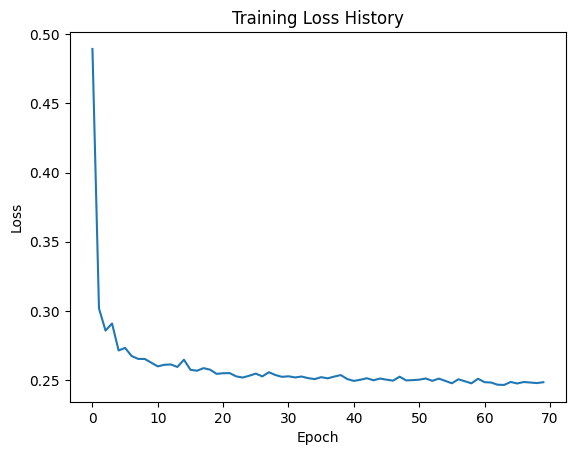

In [ ]:
lstm = LSTMModel(input_size=10, hidden_size=256, output_size=1, num_layers=2, device=device)
lstm, lstm_loss_history = train_model(lstm, dataloader, num_epochs=70, lr=0.001, plot=True)

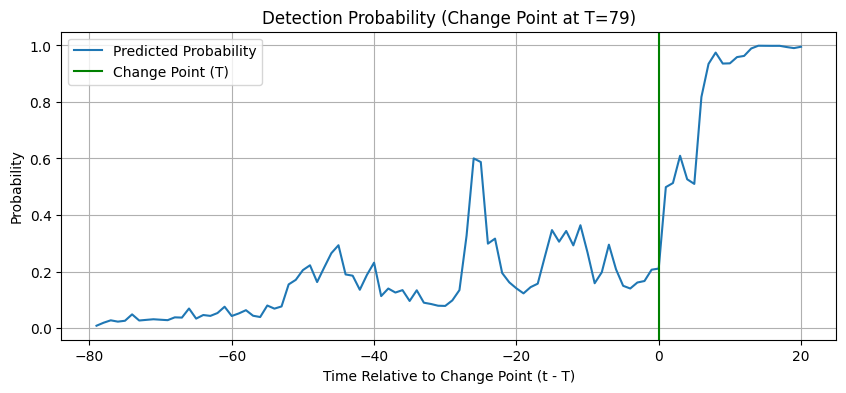

In [ ]:
seq, label, T = dataloader.dataset[0]
probabilities = get_probabilities(lstm, seq)
plot_probabilities(probabilities, T)

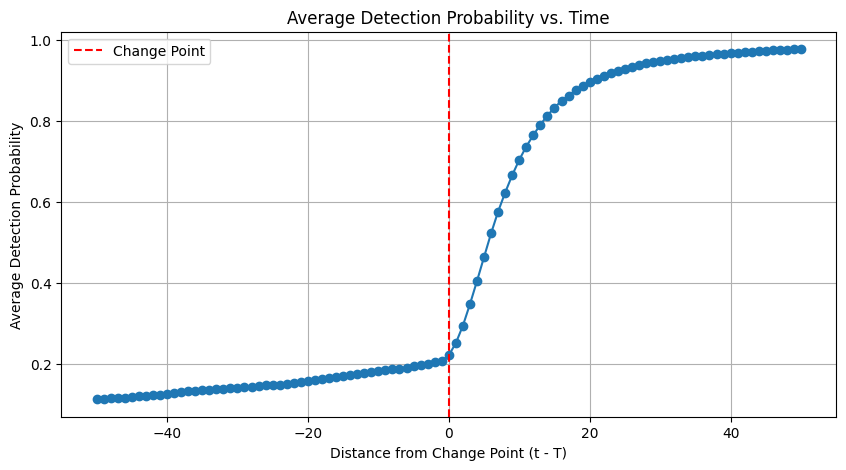

In [ ]:
evaluate_and_plot_aggregate(lstm, dataloader, device)

## 1-D CNN model

In [11]:
class CNNModel(nn.Module):
  def __init__(self, in_channels=10, out_dim=1, kernel=3, stride=1, sequence_length=100, device='cpu'):
    super(CNNModel, self).__init__()

    padding = kernel // 2 # for not having enough terms early on in conv window

    # Convolutional Layers
    self.conv_layers = nn.Sequential(
        nn.Conv1d(in_channels, 40, kernel_size=kernel, stride=stride, padding=padding),
        nn.ReLU(),
        nn.Conv1d(40, 40, kernel_size=kernel, stride=stride, padding=padding),
        nn.ReLU(),
        # Final layer to map it down to 1 dimension --> maintains time dimension
        nn.Conv1d(40, out_dim, kernel_size=1)
    )

    self.to(device)

  def forward(self, x):
    # x is (batch, time=100, features=10)
    # we want (batch, features, time)
    x = x.permute(0,2,1)

    x = self.conv_layers(x)

    # want (batch, time, out_dim=1) to compare with labels
    probabilities = torch.sigmoid(x.permute(0,2,1))

    return probabilities

## Testing CNN

Epoch 1/30, Loss: 0.6686
Epoch 6/30, Loss: 0.5442
Epoch 11/30, Loss: 0.5347
Epoch 16/30, Loss: 0.5309
Epoch 21/30, Loss: 0.5277
Epoch 26/30, Loss: 0.5254
Epoch 30/30, Loss: 0.5252


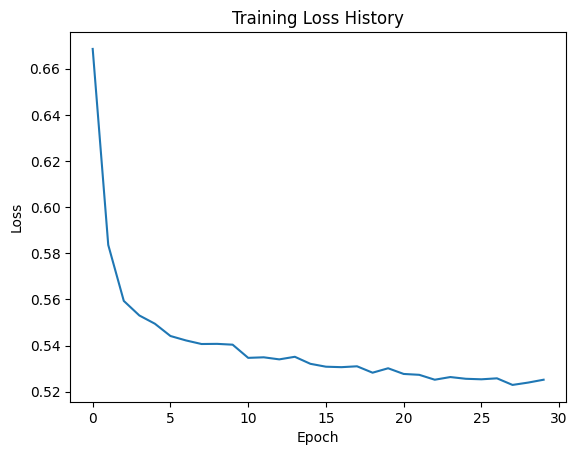

In [18]:
cnn = CNNModel(in_channels=10, out_dim=1, kernel=3, stride=1, sequence_length=100, device=device)
cnn, cnn_loss_history = train_model(cnn, dataloader, num_epochs=30, lr=0.001, plot=True)

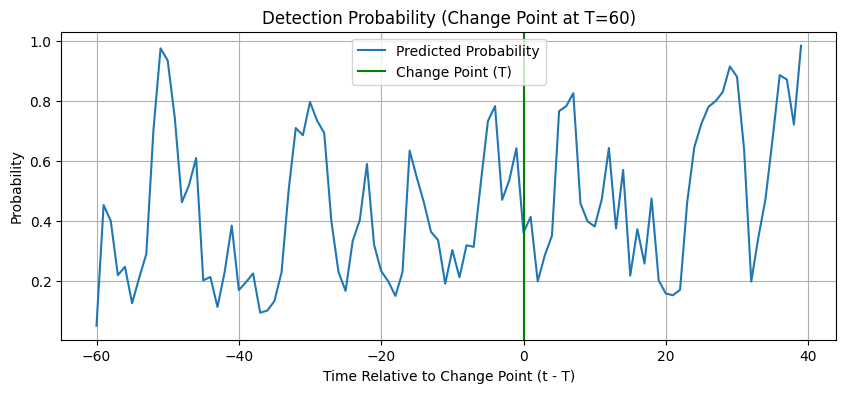

In [21]:
seq, label, T = dataloader.dataset[0]
probabilities = get_probabilities(cnn, seq)
plot_probabilities(probabilities, T)